## 5.9 Regression 실습 - Bike Sharing Demand
### 데이터 클렌징 및 가공

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('./data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


datetime: hourly date + timestamp  
season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
weather:  
• 1 = 맑음, 약간 구름 낀 흐림  
• 2 = 안개, 안개 + 흐림  
• 3 = 가벼운 눈, 가벼운 비 + 천둥  
• 4 = 심한 눈/비, 천둥/번개  
temp: 온도(섭씨)   
atemp: 체감온도(섭씨)  
humidity: 상대습도  
windspeed: 풍속  
casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
registered: 사전에 등록된 사용자가 대여한 횟수  
count: 대여 횟수  

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# 문자열을 datetime 타입으로 변경.('datetime'컬럼의 타입이 object->datetime64[ns]로 바뀜) 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [4]:
# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
print(bike_df.info())
bike_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null int64
month         10886 non-null int64
day           10886 non-null int64
hour          10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(12)
memory usage: 1.3 MB
None


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# 책에서는 mean_absolute_error()를 MSE로 잘못 기재함. 
# MAE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [10]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)
#RMSLE에 비해 RMSE와 MAE가 크게 나왔는데, 대여회수(타겟값)가 큰 값중에서 오류값이 크게 나올 경우 이렇게 나옴 

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [19]:
#RMSE 수치가 너무 높게 나와서 타겟값에서 큰 수들의 실제값과 예측값간의 오류값을 확인해보기 위해 custom함수 만들어 봄
#(타겟값중 큰 수들의 오류는 오류값이 커서 RMSE에 더 큰 영향을 주기 때문에 )
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=20)


      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0
2277         813            267.0  546.0
2314         766            222.0  544.0
454          721            177.0  544.0
1003         713            171.0  542.0
2394         684            142.0  542.0
1181         891            357.0  534.0
1379         745            212.0  533.0
2003         770            241.0  529.0
1029         901            378.0  523.0
3227         724            202.0  522.0
1038         873            353.0  520.0
3197         694            176.0  518.0
507          688            174.0  514.0
637          900            393.0  507.0
87           594             95.0  499.0


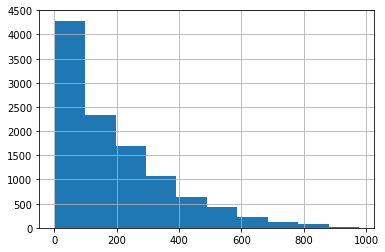

In [9]:
y_target.hist() #타겟값이 정규분포를 따르는지 제일 먼저 확인해야 함(회귀에서 정말 중요)
#그래프 그려보니, 오른쪽으로 긴 꼬리를 가지는 skew된 데이터분포를 보이고 있음(양의 왜도)

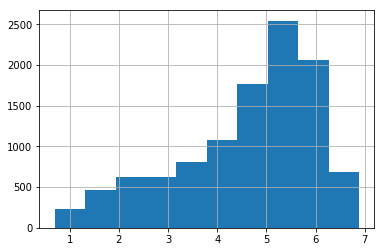

In [10]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist() #완전 정규분포라고 볼 수는 없지만 로그변환 전보다는 훨씬 더 나은 형태

In [25]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)
# 예측 값 역시 Log 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 expm1으로 scale변환
pred_exp = np.expm1(pred)
#(아래 'evaluate_regr'함수에서 rmsle에서 로그변환을 해주기 때문에 실제값, 예측값 모두 expm1 해주는 것)

evaluate_regr(y_test_exp ,pred_exp)


RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


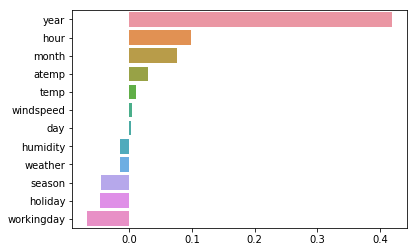

In [12]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [28]:
# 'year','month','hour','season','weather' feature들을 One Hot Encoding(categorical한 numeric변수들을 원핫인코딩 하기)
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday',
                                              'workingday','season','weather'])

-원핫인코딩에서 'day'는 제외한 이유?)  
원핫 인코딩을 적용한다고 반드시 선형 모델의 성능이 올라가진 않지만 적용하여 성능향상을 비교해 볼 수 있습니다. 비슷한 의미로 'day'의 경우는 원핫인코딩을 했을 때 오히려 성능이 떨어져서 제외했습니다.

In [33]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)


### LinearRegression ###
RMSLE: 0.589, RMSE: 97.486, MAE: 63.107
### Ridge ###
RMSLE: 0.589, RMSE: 98.407, MAE: 63.648
### Lasso ###
RMSLE: 0.634, RMSE: 113.031, MAE: 72.658


<AxesSubplot:>

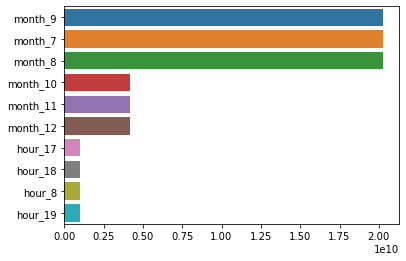

In [35]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.353, RMSE: 50.828, MAE: 31.537
### GradientBoostingRegressor ###
RMSLE: 0.340, RMSE: 55.761, MAE: 34.333
### XGBRegressor ###
RMSLE: 0.346, RMSE: 56.474, MAE: 34.917
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 46.473, MAE: 28.777


**-최종 결과 관련 선생님 설명)**  
이 데이터를 구현해 본 결과, 타겟값이 정규분포를 이루는 것이 중요하고, 피처값 중 categorical한 numeric 피처들을 원핫인코딩을 적용하는 것도 예측성능향상에 중요하다는 것을 확인할 수 있었음.(원핫 인코딩을 적용한다고 반드시 선형 모델의 성능이 올라가진 않지만 적용하여 성능향상을 비교해보는 것이 좋음)

**-추가 질문)**  
1. 회귀트리는 전처리가 필요하다면 선형모델과 똑같이 하면 되나요?  
2. 피처데이터에는 원핫인코딩 외에 로그변환같은걸 취하지 않으셨는데, 만약 데이터 돌려보고 성능이 별로면 로그변환같은걸 시도해보고 그런 식으로 진행되는건가요?  
**-답변)**
1. 일반적으로 회귀 트리의 전처리 방향성은 선형 회귀와는 좀 차이가 있습니다. 원핫 인코딩을 회귀 트리에는 적용하지 않는게 더 좋다는 의견도 있습니다(불필요한 분할을 발생시킬수 있습니다). MinMaxScaling 작업도 굳이 할 필요는 없습니다. 다만 다양한 유형의 feature engineering을 일반적으로 적용합니다. 가령 추가적인 feature를 도출한다거나, 여러개의 feature를 sum, min, max 등의 feature engineering 작업을 수행하는게 일반적입니다(물론 이것은 선형 모델도 마찬가지 입니다)  
2. 로그 변환을 포함한 feature engineering 작업에 정답은 없습니다. 다양하게 돌려보고 잘 나오면 적용하면 됩니다.  특별히 로그변환을 하지 않은 이유는 없습니다. 다만 값의 편차가 큰 feature들이 없는거 같아서 안했는데, 로그 변환을 별로 생각하지 않았는데, 로그 변환도 적용해 볼 option일 수 있겠군요. 